- [ ] checking sum rule
- [ ] optimize the numerical spike at the seperation point

In [1]:
using QuadGK, LaTeXStrings, Plots, LinearAlgebra, BenchmarkTools;
using DataFrames, CSV,Interpolations,Suppressor;
import JLD,ForwardDiff;
using Plots.PlotMeasures;

In [2]:
gr(frame=:box,size=(400, 300));

In [3]:
const unit = 1.0e-3;
const mpic = 139.57018unit; const mpi0 = 134.9766unit;
const meta = 547.862unit; const mkc = 493.677unit; const mk0 = 497.614unit;
const mpi = (2mpic + mpi0)/3; const mk = (mkc + mk0)/2;
const mπ=mpi;
const mJψ=3.0969;

In [4]:
# redefine sqrt so that its cut is along the positive x axis
function xsqrt(x)
    imag(x) >= 0 ? sqrt(x + 0im) : -sqrt(x - 0im)
end

# redefine angle so that its cut is along the positive x axis
function xangle(x)
    imag(x) >= 0 ? angle(x + 0im) : angle(x) + 2 * π
end

# redefine log so that its cut is along the positive x axis
function xlog(x)
    imag(x) >= 0 ? log(x + 0im) : log(x) + im * 2 * π
end
λ(x, y, z) = x^2 + y^2 + z^2 - 2 * x * y - 2 * x * z - 2 * y * z;

# Load data and interpolation

In [5]:
df_ps_pipi_black = sort(DataFrame(CSV.File("./data/ps_pipi_black.csv")));
df_ps_pipi_blue = sort(DataFrame(CSV.File("./data/ps_pipi_blue.csv")));
df_ps_pipi_green = sort(DataFrame(CSV.File("./data/ps_pipi_green.csv")));
df_ps_pipi_red = sort(DataFrame(CSV.File("./data/ps_pipi_red.csv")));

In [6]:
inte_ps_pipi_black = LinearInterpolation(collect(df_ps_pipi_black.Sqrts), collect(df_ps_pipi_black.delta));
inte_ps_pipi_blue = LinearInterpolation(collect(df_ps_pipi_blue.Sqrts), collect(df_ps_pipi_blue.delta));
inte_ps_pipi_green = LinearInterpolation(collect(df_ps_pipi_green.Sqrts), collect(df_ps_pipi_green.delta));
inte_ps_pipi_red = LinearInterpolation(collect(df_ps_pipi_red.Sqrts), collect(df_ps_pipi_red.delta));

In [7]:
inte_ps_pipi_black_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_black(sqrt(s))/180*π
inte_ps_pipi_blue_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_blue(sqrt(s))/180*π
inte_ps_pipi_green_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_green(sqrt(s))/180*π
inte_ps_pipi_red_s(s)=s<=4*mpi^2 ? 0.0 : inte_ps_pipi_red(sqrt(s))/180*π

inte_ps_pipi_red_s (generic function with 1 method)

In [8]:
function phase_pipi_black(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_black_s(s)
    end
    α=3*(π-inte_ps_pipi_black_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_black_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_black_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_black_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

function phase_pipi_blue(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_blue_s(s)
    end
    α=3*(π-inte_ps_pipi_blue_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_blue_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_blue_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_blue_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

function phase_pipi_green(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_green_s(s)
    end
    α=3*(π-inte_ps_pipi_green_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_green_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_green_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_green_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end
function phase_pipi_red(s; sth=4*mpi^2, scut=1.85^2)
    if s < sth
        return 0.0
    elseif sth <= s && s <= scut
        return inte_ps_pipi_red_s(s)
    end
    α=3*(π-inte_ps_pipi_red_s(scut))^2/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_red_s(s), scut))
    β=-1+3*(π-inte_ps_pipi_red_s(scut))/(2*scut*ForwardDiff.derivative(s -> inte_ps_pipi_red_s(s), scut))
    return π-α/(β+(s/scut)^(3/2))
end

phase_pipi_red (generic function with 1 method)

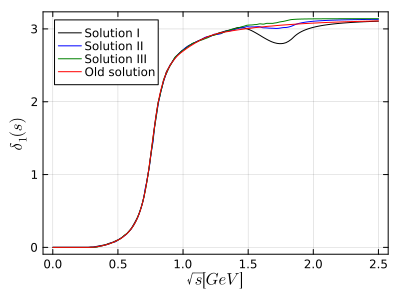

In [9]:
plot(0.0:0.01:2.5,e->phase_pipi_black(e^2),lc=:black,label="Solution I",xlabel=L"\sqrt{s}[GeV]",ylabel=L"\delta_1(s)")
plot!(0.0:0.01:2.5,e->phase_pipi_blue(e^2),lc=:blue,label="Solution II")
plot!(0.0:0.01:2.5,e->phase_pipi_green(e^2),lc=:green,label="Solution III")
plot!(0.0:0.01:2.5,e->phase_pipi_red(e^2),lc=:red,label="Old solution")

In [10]:
function dispersion_integral(f, x, sth; nsub=1)  # these dispersion relation are actually subtracting at s=0
    iϵ = 1e-8im
    res = 0.0im
    if nsub == 1
        integrand1(x′) = f(x′) / (x′ * (x′ - x - iϵ))
        res = quadgk(integrand1, sth, Inf)[1] / π * x
    elseif nsub == 0
        integrand(x′) = f(x′) / (x′ - x - iϵ)
        res = quadgk(integrand, sth, Inf)[1] / π
    end
    return res
end

function Omnes_complex(f, x, sth)
    exp(dispersion_integral(f, x, sth))
end

Omnes_complex (generic function with 1 method)

In [11]:
Ω1_black(s)=Omnes_complex(phase_pipi_black,s,4*mpi^2)
Ω1_blue(s)=Omnes_complex(phase_pipi_blue,s,4*mpi^2)
Ω1_green(s)=Omnes_complex(phase_pipi_green,s,4*mpi^2)
Ω1_red(s)=Omnes_complex(phase_pipi_red,s,4*mpi^2)
Ω1_all(s;ps=phase_pipi_black)=Omnes_complex(ps,s,4*mpi^2)

Ω1_all (generic function with 1 method)

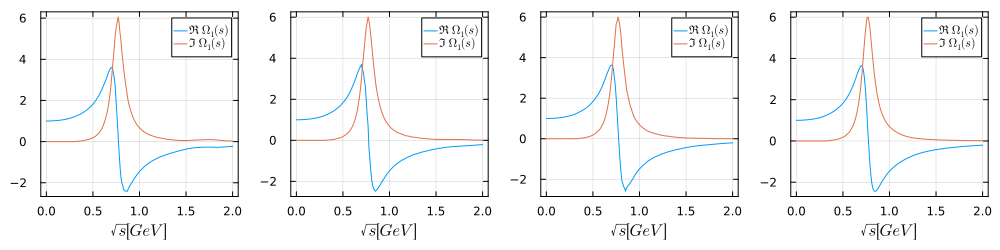

In [12]:
let
    Ev=0.0:0.01:2.0
    resv1=Ω1_black.(Ev .^2)
    resv2=Ω1_blue.(Ev .^2)
    resv3=Ω1_green.(Ev .^2)
    resv4=Ω1_red.(Ev .^2)
    plt1=plot(Ev,real.(resv1),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)",bottom_margin=7mm)
    plot!(Ev,imag.(resv1),label=L"\Im\ \Omega_1(s)")
    plt2=plot(Ev,real.(resv2),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv2),label=L"\Im\ \Omega_1(s)")
    plt3=plot(Ev,real.(resv3),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv3),label=L"\Im\ \Omega_1(s)")
    plt4=plot(Ev,real.(resv4),xlabel=L"\sqrt{s}[GeV]",label=L"\Re\ \Omega_1(s)")
    plot!(Ev,imag.(resv4),label=L"\Im\ \Omega_1(s)")
    plot(plt1,plt2,plt3,plt4,layout=(1,4),size=(1000,250))
end

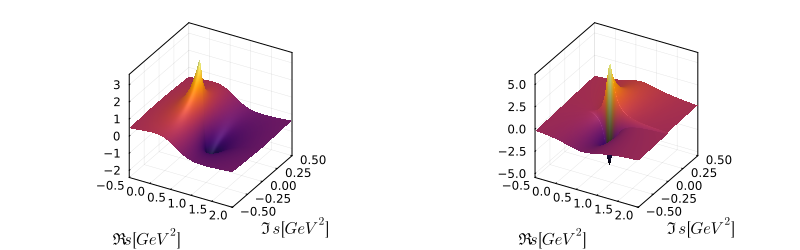

In [13]:
let Resv=-0.5:0.01:2.0,Imsv=-0.5:0.01:0.5
    res_mat=[Ω1_black(x+im*y) for y in Imsv,x in Resv]
    plot(surface(Resv,Imsv,real.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),
        surface(Resv,Imsv,imag.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),layout=(1,2),size=(800,250))
end

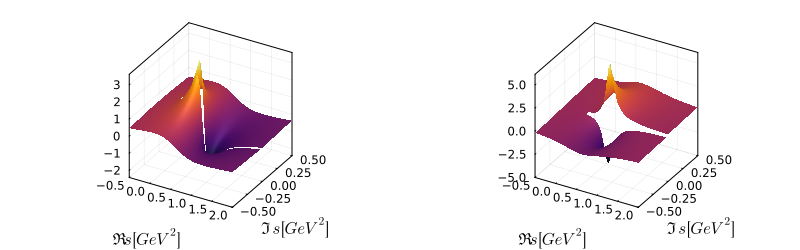

In [14]:
let Resv=-0.5:0.01:2.0,Imsv=-0.5:0.01:0.5
    # set value on the lower rim above the threshold to NaN so that the plot shows the cut
    res_mat=[(x>4*mpi^2&&y≈-0.01) ? NaN+im*NaN : Ω1_black(x+im*y) for y in Imsv,x in Resv]
    plot(surface(Resv,Imsv,real.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),
        surface(Resv,Imsv,imag.(res_mat),xlabel=L"\Re s[GeV^2]",ylabel=L"\Im s[GeV^2]",legend=false),layout=(1,2),size=(800,250))
end

In [13]:
sinδ_absΩ(s;ps=phase_pipi_black)=sin(ps(s))/abs(Ω1_all(s;ps=ps))

sinδ_absΩ (generic function with 1 method)

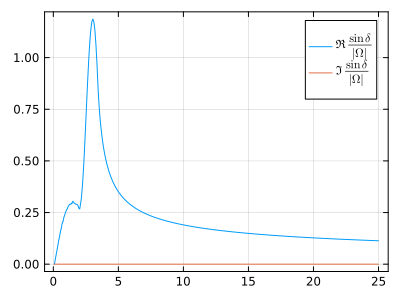

In [16]:
let sv=collect(4*mpi^2:0.01:5^2)
    resv=sinδ_absΩ.(sv;ps=phase_pipi_black)
    plot(sv,real.(resv),label=L"\Re\frac{\sin\delta}{|\Omega|}")
    plot!(sv,imag.(resv),label=L"\Im\frac{\sin\delta}{|\Omega|}")
end

# Solve the KT equation

## analytical continuation of mandelstam limits

\begin{align}
\kappa_s(s)&=\frac{\sqrt{s+i\epsilon}\sqrt{s-4m_{\pi}^2+i\epsilon}\sqrt{(m_{J/\psi}-m_{\pi})^2-s+i\epsilon}\sqrt{(m_{J/\psi}+m_{\pi})^2-s+i\epsilon}}{s}\\
s^{\pm}&=\frac{1}{2}(\Sigma_0-s\pm\kappa_s),\Sigma_0=m_{J/\psi}^2+3m_{\pi}^2
\end{align}

In [14]:
function κs(s)
    res = zero(ComplexF64)
    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res=√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res=im*√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    elseif s >= (mJψ + mpi)^2
        res=(-1)*√abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))
    end
    return res 
end
function splus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2 
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    end

    return res
end

function sminus(s; ϵ=1.0e-7)
    Σ0 = mJψ^2 + 3*mπ^2
    res = 0.0im

    if 4*mpi^2 <= s && s < (mJψ^2 - mpi^2)/2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) + im * ϵ
    elseif (mJψ^2 - mpi^2)/2 <= s && s < (mJψ - mpi)^2
        res = 1 / 2 * (Σ0 - s - √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    elseif (mJψ - mpi)^2 <= s && s < (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s - im * √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    elseif s >= (mJψ + mpi)^2
        res = 1 / 2 * (Σ0 - s + √abs(λ(s, mπ^2, mπ^2)) / s * √(abs(λ(s, mJψ^2, mπ^2)))) - im * ϵ
    end
end

sminus (generic function with 1 method)

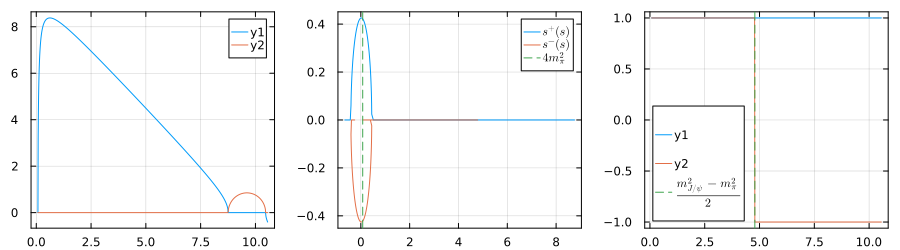

In [15]:
let sv=collect(4*mpi^2:0.01:(mJψ+mpi)^2+0.1)
    plt1=plot(sv,s->real(κs(s)))
    plot!(sv,s->imag(κs(s)))
    
    resv1,resv2=splus.(sv),sminus.(sv)
    #plot the trajectory
    plt2=plot(real.(resv1),imag.(resv1),label=L"s^{+}(s)")
    plot!(real.(resv2),imag.(resv2),label=L"s^{-}(s)")
    vline!([4*mpi^2],ls=:dash,label=L"4m_{\pi}^2")
    #ensure the sign of the imaginary part
    plt3=plot(sv,sign.(imag.(resv1)))
    plot!(sv,sign.(imag.(resv2)))
    vline!([(mJψ^2-mpi^2)/2],ls=:dash,label=L"\frac{m_{J/\psi}^2-m_{\pi}^2}{2}")
    
    plot(plt1,plt2,plt3,layout=(1,3),size=(900,250))
end

## solve by iteration
For coping with singular integral numerically, refer to https://link.springer.com/article/10.1140/epjc/s10052-018-6377-9. 

In [15]:
import NumericalIntegration,JLD;

In [16]:
hfunc(t,a,b,c)=(t-a)*(c-t)/(b-a)/(c-b);
function Gfunc(s,a,b,c;ϵ=1.0e-8)
    ω,ω1,ω3=xsqrt(b-s-im*ϵ),xsqrt(b-a),xsqrt(b-c-im*ϵ)
    2*hfunc(s,a,b,c)/ω^3*(atanh(ω1/ω)-atanh(ω3/ω))-2*(1/ω1-1/ω3)*(1/ω^2-1/ω1/ω3)
end

Gfunc (generic function with 1 method)

In [17]:
xxxwww=gauss(199,0,1);
xxx=vcat(0.0,xxxwww[1]);
lenx=length(xxx);
function getintegralpoints(endpoints;xxx=xxx)
    g(z1,z2)=broadcast(x->z1*(1-x)+z2*x,xxx)
    resvec=[]
    for i in 1:length(endpoints)-1
        append!(resvec,g(endpoints[i],endpoints[i+1])...)
    end
    resvec
end

getintegralpoints (generic function with 1 method)

In [18]:
(mJψ-mpi),(mJψ+mpi)

(2.9588610133333337, 3.2349389866666667)

In [19]:
const spath_vec=getintegralpoints([4*mpi^2,0.5,1.0,1.5,2.5,2.5^2,(mJψ-mpi)^2,(mJψ+mpi)^2,5.0^2]); # cutoff=5.0^2

In [20]:
lens=length(spath_vec)

1600

In [21]:
spath_curve=vcat(reverse(sminus.(spath_vec)),splus.(spath_vec));

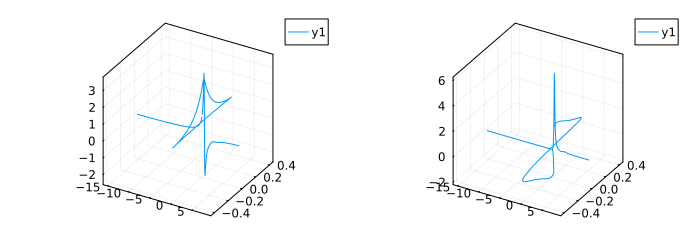

In [27]:
let
    resv=Ω1_all.(spath_curve;ps=phase_pipi_black)
    plt1=plot(real.(spath_curve),imag.(spath_curve),real.(resv))
    plt2=plot(real.(spath_curve),imag.(spath_curve),imag.(resv))
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

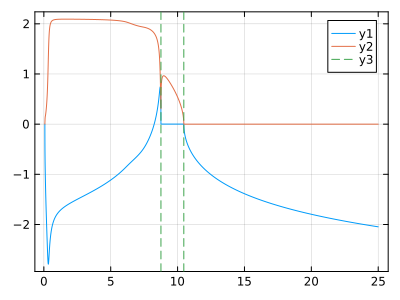

In [28]:
let
    Ω1_arr=Ω1_all.(spath_curve;ps=phase_pipi_black)
    resv=zeros(ComplexF64,lens)
    for i in 1:lens
        resv[i]=NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],Ω1_arr[lens-i+1:lens+i])
    end
    plot(spath_vec,real.(resv))
    plot!(spath_vec,imag.(resv))
    vline!([(mJψ-mpi)^2,(mJψ+mpi)^2],ls=:dash)
end

In [22]:
sinδ_absΩ_arr=sinδ_absΩ.(spath_vec;ps=phase_pipi_black);

In [23]:
Ω1_arr_curve=Ω1_all.(spath_curve;ps=phase_pipi_black);

In [24]:
function disperfunc(s;nsub=1,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-3)
    s1,s2,s3,s4,scut=(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ-mpi)^2,((mJψ-mpi)^2+(mJψ+mpi)^2)/2,(mJψ+mpi)^2,5.0^2
    kerfunc=LinearInterpolation(spath_vec,(sinδ_absΩ_arr .*Ft_arr),extrapolation_bc=Line())

    res=zero(ComplexF64)
    Ω1_s=Ω1_all(s)
    
    # attributions from the first part of integral
    res+=Ω1_s*s^nsub/π*quadgk(x->1/x^nsub*kerfunc(x)/κs(x)^3/(x-s-im*ϵ),4*mpi^2,s1;rtol=rtol)[1]

    # attributions from the second part of integral
    Hfunc=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ+mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H_s2=Hfunc(s2)
    spath_sub=spath_vec[s1-0.1 .<spath_vec .<s3+0.1]
    func_derivative=LinearInterpolation(spath_sub,broadcast(x->(Hfunc(x)-hfunc(x,s1,s2,s3)*H_s2)/((mJψ-mpi)^2-x+im*ϵ),spath_sub),extrapolation_bc=Line())
    res+=Ω1_s*s^nsub/π*quadgk(x->func_derivative(x)/sqrt((mJψ-mpi)^2-x+im*ϵ)/(x-s-im*ϵ),s1,s3;rtol=rtol)[1]
    res+=Ω1_s*s^nsub/π*H_s2*Gfunc(s,s1,s2,s3)

    # attributions from the third part of integral
    Hfunc1=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ-mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H1_s4=Hfunc1(s4)
    spath_sub1=spath_vec[s3-0.1 .<spath_vec]
    func_derivative1=LinearInterpolation(spath_sub1,broadcast(x->(Hfunc1(x)-hfunc(x,s3,s4,scut)*H1_s4)/((mJψ+mpi)^2-x+im*ϵ),spath_sub1),extrapolation_bc=Line())
    res+=Ω1_s*s^nsub/π*quadgk(x->func_derivative1(x)/sqrt((mJψ+mpi)^2-x+im*ϵ)/(x-s-im*ϵ),s3,scut;rtol=rtol)[1]
    res+=Ω1_s*s^nsub/π*H1_s4*Gfunc(s,s3,s4,scut)
    
    return res
end

disperfunc (generic function with 1 method)

In [25]:
function KT_iteration!(;nsub=1,Ft_arr_init=Ftilde_arr_initial,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-3)
    s1,s2,s3,s4,scut=(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ-mpi)^2,((mJψ-mpi)^2+(mJψ+mpi)^2)/2,(mJψ+mpi)^2,5.0^2
    kerfunc=LinearInterpolation(spath_vec,(sinδ_absΩ_arr .*Ft_arr),extrapolation_bc=Line())

    # attributions from the first part of integral
    println("Processing the first integral...")
    res_arr1=@. Ω1_arr_curve*spath_curve^nsub/π*quadgk(x->(@. 1/(x-spath_curve-im*ϵ)) .*1/x^nsub*kerfunc(x)/κs(x)^3,4*mpi^2,s1;rtol=rtol)[1]
    
    # attributions from the second part of integral
    println("Processing the second integral...")
    Hfunc=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ+mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H_s2=Hfunc(s2)
    spath_sub=spath_vec[s1-0.1 .<spath_vec .<s3+0.1]
    func_derivative=LinearInterpolation(spath_sub,broadcast(x->(Hfunc(x)-hfunc(x,s1,s2,s3)*H_s2)/((mJψ-mpi)^2-x+im*ϵ),spath_sub),extrapolation_bc=Line())
    res_arr2=@. Ω1_arr_curve*spath_curve^nsub/π*quadgk(x->(@. 1/(x-spath_curve-im*ϵ)) .*func_derivative(x)/sqrt((mJψ-mpi)^2-x+im*ϵ),s1,s3;rtol=rtol)[1]
    res_arr2 .+=@. Ω1_arr_curve*spath_curve^nsub/π*H_s2*broadcast(z->Gfunc(z,s1,s2,s3),spath_curve)

    # attributions from the third part of integral
    println("Processing the third integral...")
    Hfunc1=LinearInterpolation(spath_vec,(@. 1/spath_vec^nsub*sinδ_absΩ_arr*Ft_arr/(sqrt(spath_vec+im*ϵ)*sqrt(spath_vec-4*mpi^2+im*ϵ)*sqrt((mJψ-mpi)^2-spath_vec+im*ϵ))^3),extrapolation_bc=Line())
    H1_s4=Hfunc1(s4)
    spath_sub1=spath_vec[s3-0.1 .<spath_vec]
    func_derivative1=LinearInterpolation(spath_sub1,broadcast(x->(Hfunc1(x)-hfunc(x,s3,s4,scut)*H1_s4)/((mJψ+mpi)^2-x+im*ϵ),spath_sub1),extrapolation_bc=Line())
    res_arr3=@. Ω1_arr_curve*spath_curve^nsub/π*quadgk(x->(@. 1/(x-spath_curve-im*ϵ)) .*func_derivative1(x)/sqrt((mJψ+mpi)^2-x+im*ϵ),s3,scut;rtol=rtol)[1]
    res_arr3 .+=@. Ω1_arr_curve*spath_curve^nsub/π*H1_s4*broadcast(z->Gfunc(z,s3,s4,scut),spath_curve)

    # updating the Ftilde arrays
    res_arr=(@. res_arr1+res_arr2+res_arr3)
    Ft_addarr=zeros(ComplexF64,lens)
    Σ0=mJψ^2+3*mpi^2
    for i in 1:lens
        s=spath_vec[i]
        κs0=κs(s)
        temp_arr=@. κs0^2-(2*spath_curve[lens-i+1:lens+i]-Σ0+s)^2
        Ft_addarr[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*res_arr[lens-i+1:lens+i])
    end
    Ft_arr .=@. Ft_arr_init+Ft_addarr
    nothing
end

KT_iteration! (generic function with 1 method)

### Excuting only for 1 subtraction

In [26]:
Ftilde_arr_initial=zeros(ComplexF64,lens); # inhomogeneities only from the Omnes function part

In [27]:
for i in 1:lens
    s=spath_vec[i]
    Σ0=mJψ^2+3*mpi^2
    κs0=κs(s)
    temp_arr=(@. κs0^2-(2*spath_curve[lens-i+1:lens+i]-Σ0+s)^2)
    Ftilde_arr_initial[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*Ω1_arr_curve[lens-i+1:lens+i])
end

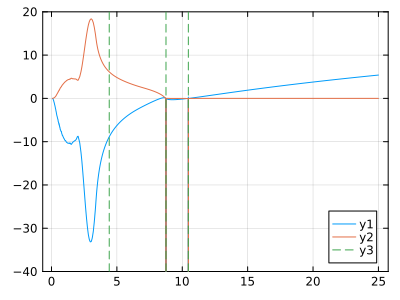

In [30]:
let index=4*mpi^2 .<spath_vec .<25
    tmp_arr=@. sinδ_absΩ_arr*Ftilde_arr_initial/κs(spath_vec) #/κs(spath_vec)^3
    plot(spath_vec[index],real.(tmp_arr[index]),ylims=(-40,20))
    plot!(spath_vec[index],imag.(tmp_arr[index]))
    vline!([(4mpi^2+(mJψ-mpi)^2)/2,(mJψ-mpi)^2,(mJψ+mpi)^2],ls=:dash)
end

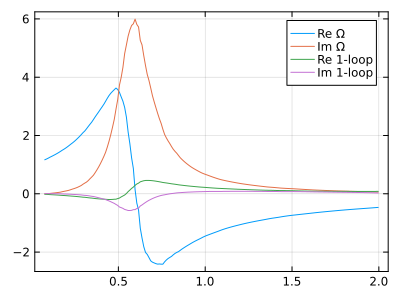

In [30]:
let sv=collect(4*mpi^2:0.01:2.0)
    resv=[disperfunc(s;Ft_arr=Ftilde_arr_initial) for s in sv]
    Ω1_arr=Ω1_all.(sv)
    plot(sv,real.(Ω1_arr),label="Re Ω")
    plot!(sv,imag.(Ω1_arr),label="Im Ω")
    plot!(sv,real.(resv),label="Re 1-loop")
    plot!(sv,imag.(resv),label="Im 1-loop")
end

In [26]:
Ftilde_arr=zeros(ComplexF64,lens); # current inhomogeneities

In [31]:
Ftilde_iter=[zeros(ComplexF64,lens) for i in 1:5];

In [41]:
for i in 1:5
    println(i)
    KT_iteration!(;nsub=1,Ft_arr_init=Ftilde_arr_initial,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-3) 
    Ftilde_iter[i] .=Ftilde_arr
end

In [ ]:
plot(spath_vec,real.(Ftilde_arr),label="Re");plot!(spath_vec,imag.(Ftilde_arr),label="Im")

In [ ]:
JLD.save("./output/KT_Ftilde_P_1sub.jld","Ftilde_mat",Ftilde_iter);

In [32]:
Ftilde_iter=JLD.load("./output/KT_Ftilde_P_1sub.jld")["Ftilde_mat"];

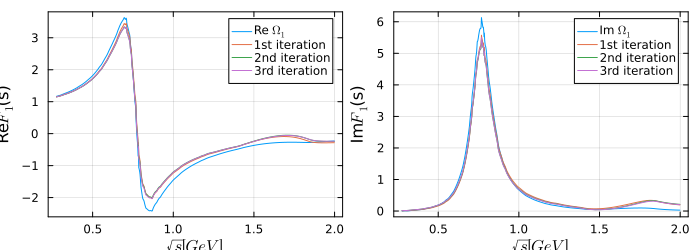

In [33]:
let Ev=collect(2*mpi:0.002:2.0)
    Ω1_arr=Ω1_all.(Ev .^2)
    resv1=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[1]) for e in Ev]
    resv2=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[2]) for e in Ev]
    resv3=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[3]) for e in Ev]
    resv4=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[4]) for e in Ev]
    resv5=@. Ω1_arr+[disperfunc(e^2;Ft_arr=Ftilde_iter[5]) for e in Ev]
    plt1=plot(Ev,real.(Ω1_arr),label=L"Re $Ω_1$",xlabel=L"\sqrt{s}[GeV]",ylabel=L"Re$F_1$(s)")
    plot!(Ev,real.(resv1),label="1st iteration")
    plot!(Ev,real.(resv2),label="2nd iteration")
    plot!(Ev,real.(resv3),label="3rd iteration")
    # plot!(Ev,real.(resv4),label="4th iteration")
    # plot!(Ev,real.(resv5),label="5th iteration")
    plt2=plot(Ev,imag.(Ω1_arr),label=L"Im $Ω_1$",xlabel=L"\sqrt{s}[GeV]",ylabel=L"Im$F_1$(s)")
    plot!(Ev,imag.(resv1),label="1st iteration")
    plot!(Ev,imag.(resv2),label="2nd iteration")
    plot!(Ev,imag.(resv3),label="3rd iteration")
    # plot!(Ev,imag.(resv4),label="4th iteration")
    # plot!(Ev,imag.(resv5),label="5th iteration")
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

### Excuting only for 2 subtractions

In [25]:
Ftilde_arr_initial_a=zeros(ComplexF64,lens);
Ftilde_arr_initial_b=zeros(ComplexF64,lens);

In [26]:
for i in 1:lens
    s=spath_vec[i]
    Σ0=mJψ^2+3*mpi^2
    κs0=κs(s)
    temp_arr=(@. κs0^2-(2*spath_curve[lens-i+1:lens+i]-Σ0+s)^2)
    Ftilde_arr_initial_a[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*Ω1_arr_curve[lens-i+1:lens+i])
    Ftilde_arr_initial_b[i]=3*NumericalIntegration.integrate(spath_curve[lens-i+1:lens+i],temp_arr .*Ω1_arr_curve[lens-i+1:lens+i] .*spath_curve[lens-i+1:lens+i])
end

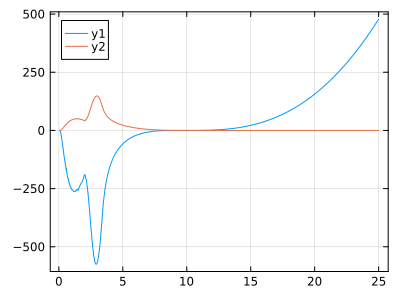

In [27]:
let index=4*mpi^2 .<spath_vec .<25.0
    tmp_arr=@. sinδ_absΩ_arr*Ftilde_arr_initial_b  #/κs(spath_vec)^3
    plot(spath_vec[index],real.(tmp_arr[index]))#,ylims=(-2,2))
    plot!(spath_vec[index],imag.(tmp_arr[index]))
end

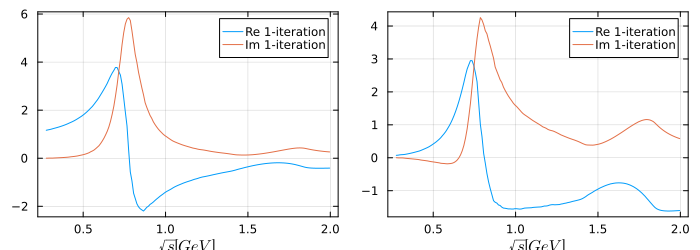

In [29]:
let Ev=collect(2*mpi:0.01:2.0),rtol=1e-2,nsub=2
    sv=Ev .^2
    Ω1_arr=Ω1_all.(sv)
    
    resv1=[disperfunc(e^2;nsub=nsub,Ft_arr=Ftilde_arr_initial_a,rtol=rtol) for e in Ev]
    resv2=[disperfunc(e^2;nsub=nsub,Ft_arr=Ftilde_arr_initial_b,rtol=rtol) for e in Ev]
    
    plt1=plot(Ev,real.(Ω1_arr .+resv1),label="Re 1-iteration",xlabel=L"\sqrt{s}[GeV]")
    plot!(Ev,imag.(Ω1_arr .+resv1),label="Im 1-iteration")
    plt2=plot(Ev,real.(@. (Ω1_arr*sv +resv2)),label="Re 1-iteration",xlabel=L"\sqrt{s}[GeV]")
    plot!(Ev,imag.(@. (Ω1_arr*sv +resv2)),label="Im 1-iteration")
    
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

In [27]:
Ftilde_iter_a=[zeros(ComplexF64,lens) for i in 1:10];
Ftilde_iter_b=[zeros(ComplexF64,lens) for i in 1:10];

In [31]:
Ftilde_arr=zeros(ComplexF64,lens); # remember to set the current inhomogeneities to zeros

In [35]:
for i in 1:9 # this iteration shall saturate in the 6-th time
    println(i)
    KT_iteration!(;nsub=2,Ft_arr_init=Ftilde_arr_initial_a,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-2) 
    Ftilde_iter_a[i] .=Ftilde_arr
end

7
Processing the first integral...
Processing the second integral...
Processing the third integral...
8
Processing the first integral...
Processing the second integral...
Processing the third integral...
9
Processing the first integral...
Processing the second integral...
Processing the third integral...


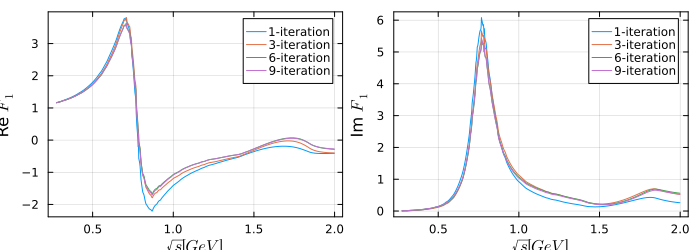

In [39]:
let Ev=collect(2*mpi:0.002:2.0),nsub=2,rtol=1e-2
    sv=Ev .^2
    resv1=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_a[1],rtol=rtol) for s in sv]
    resv3=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_a[3],rtol=rtol) for s in sv]
    resv6=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_a[6],rtol=rtol) for s in sv]
    resv9=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_a[9],rtol=rtol) for s in sv]
    Ω1_arr=Ω1_all.(sv)
    plt1=plot(Ev,real.(Ω1_arr .+resv1),label="1-iteration",ylabel=L"Re $F_1$",xlabel=L"\sqrt{s}[GeV]")
    plot!(Ev,real.(Ω1_arr .+resv3),label="3-iteration")
    plot!(Ev,real.(Ω1_arr .+resv6),label="6-iteration")
    plot!(Ev,real.(Ω1_arr .+resv9),label="9-iteration")
    plt2=plot(Ev,imag.(Ω1_arr .+resv1),label="1-iteration",ylabel=L"Im $F_1$",xlabel=L"\sqrt{s}[GeV]")
    plot!(Ev,imag.(Ω1_arr .+resv3),label="3-iteration")
    plot!(Ev,imag.(Ω1_arr .+resv6),label="6-iteration")
    plot!(Ev,imag.(Ω1_arr .+resv9),label="9-iteration")
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

In [40]:
JLD.save("./output/KT_Ftilde_P_2sub_a.jld","Ftilde_a_mat",Ftilde_iter_a);

In [28]:
Ftilde_arr=zeros(ComplexF64,lens); # remember to set the current inhomogeneities to zeros

In [29]:
for i in 1:9 # this iteration shall saturate in the 6-th time
    println(i)
    KT_iteration!(;nsub=2,Ft_arr_init=Ftilde_arr_initial_b,Ft_arr=Ftilde_arr,ϵ=1.0e-8,rtol=1e-2) 
    Ftilde_iter_b[i] .=Ftilde_arr
end

1
Processing the first integral...
Processing the second integral...
Processing the third integral...
2
Processing the first integral...
Processing the second integral...
Processing the third integral...
3
Processing the first integral...
Processing the second integral...
Processing the third integral...
4
Processing the first integral...
Processing the second integral...
Processing the third integral...
5
Processing the first integral...
Processing the second integral...
Processing the third integral...
6
Processing the first integral...
Processing the second integral...
Processing the third integral...
7
Processing the first integral...
Processing the second integral...
Processing the third integral...
8
Processing the first integral...
Processing the second integral...
Processing the third integral...
9
Processing the first integral...
Processing the second integral...
Processing the third integral...


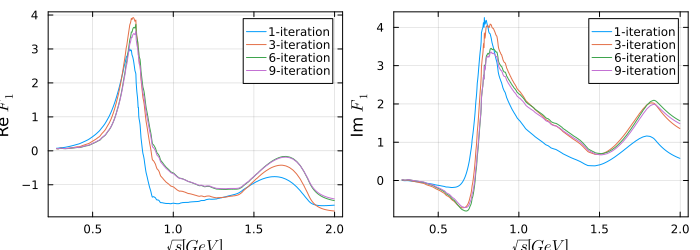

In [30]:
let Ev=collect(2*mpi:0.002:2.0),nsub=2,rtol=1e-2
    sv=Ev .^2
    resv1=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_b[1],rtol=rtol) for s in sv]
    resv3=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_b[3],rtol=rtol) for s in sv]
    resv6=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_b[6],rtol=rtol) for s in sv]
    resv9=[disperfunc(s;nsub=nsub,Ft_arr=Ftilde_iter_b[9],rtol=rtol) for s in sv]
    Ω1_arr=Ω1_all.(sv) .*sv
    plt1=plot(Ev,real.(Ω1_arr .+resv1),label="1-iteration",ylabel=L"Re $F_1$",xlabel=L"\sqrt{s}[GeV]")
    plot!(Ev,real.(Ω1_arr .+resv3),label="3-iteration")
    plot!(Ev,real.(Ω1_arr .+resv6),label="6-iteration")
    plot!(Ev,real.(Ω1_arr .+resv9),label="9-iteration")
    plt2=plot(Ev,imag.(Ω1_arr .+resv1),label="1-iteration",ylabel=L"Im $F_1$",xlabel=L"\sqrt{s}[GeV]")
    plot!(Ev,imag.(Ω1_arr .+resv3),label="3-iteration")
    plot!(Ev,imag.(Ω1_arr .+resv6),label="6-iteration")
    plot!(Ev,imag.(Ω1_arr .+resv9),label="9-iteration")
    plot(plt1,plt2,layout=(1,2),size=(700,250))
end

In [31]:
JLD.save("./output/KT_Ftilde_P_2sub_b.jld","Ftilde_b_mat",Ftilde_iter_b);

# Fitting

In [28]:
Ftilde_sub_mat=JLD.load("./output/KT_Ftilde_P_1sub.jld")["Ftilde_mat"];
Ftilde_a_mat=JLD.load("./output/KT_Ftilde_P_2sub_a.jld")["Ftilde_a_mat"];
Ftilde_b_mat=JLD.load("./output/KT_Ftilde_P_2sub_b.jld")["Ftilde_b_mat"];

## checking sum rule (not right!)

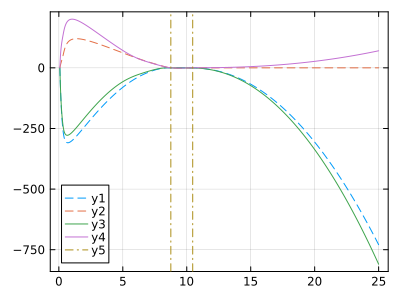

In [34]:
plot(spath_vec,real.(@. Ftilde_arr_initial),ls=:dash)  #/κs(spath_vec)^3
plot!(spath_vec,imag.(@. Ftilde_arr_initial),ls=:dash)
plot!(spath_vec,real.(@. Ftilde_sub_mat[5]))  #/κs(spath_vec)^3
plot!(spath_vec,imag.(@. Ftilde_sub_mat[5]))  #/κs(spath_vec)^3
vline!([(mJψ-mpi)^2,(mJψ+mpi)^2],ls=:dashdot)

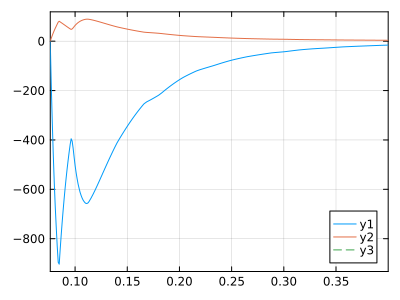

In [68]:
# # let Ft_arr=Ftilde_sub_mat[5],nsub=2,ϵ=1.0e-8
let Ft_arr=Ftilde_arr_initial,nsub=2,ϵ=1.0e-8
    sth,sp,st,scut=4mpi^2,(mJψ-mpi)^2,(mJψ+mpi)^2,5.0^2
    s1=(sp+st)/2
    kerfunc=LinearInterpolation(spath_vec,(sinδ_absΩ_arr .*Ft_arr),extrapolation_bc=Line())
    f(x)=1/x^nsub*kerfunc(x)/(sqrt(x+im*ϵ)*sqrt(x-sth+im*ϵ)*sqrt(st-x+im*ϵ))^3
    g(x)=1/x^nsub*kerfunc(x)/(sqrt(x+im*ϵ)*sqrt(x-sth+im*ϵ)*sqrt(sp-x+im*ϵ))^3
    xv1,xv2=collect(range(sth,stop=s1,length=10000)),collect(range(s1,stop=scut,length=10000))
    fp0,gt0=f(sp),g(st)
    df=LinearInterpolation(xv1,broadcast(x->(f(x)-fp0)/(sp-x+im*ϵ),xv1),extrapolation_bc=Line())
    dg=LinearInterpolation(xv2,broadcast(x->(g(x)-gt0)/(st-x+im*ϵ),xv2),extrapolation_bc=Line())
    plot(xv1,real.(df.(xv1)),xlims=(sth,0.4))
    plot!(xv1,imag.(df.(xv1)))
    # plot(xv2,real.(dg.(xv2)),xlims=(s1,scut))
    # plot!(xv2,imag.(dg.(xv2)))
    vline!([sp,st],ls=:dash)
end

In [59]:
function cal_sumrule(;Ft_arr=Ftilde_sub_mat[5],nsub=2,ϵ=1.0e-8)
    sth,sp,st,scut=4*mpi^2,(mJψ-mpi)^2,(mJψ+mpi)^2,5.0^2
    s1=(sp+st)/2
    kerfunc=LinearInterpolation(spath_vec,(sinδ_absΩ_arr .*Ft_arr),extrapolation_bc=Line())
    f(x)=1/x^nsub*kerfunc(x)/(sqrt(x+im*ϵ)*sqrt(x-sth+im*ϵ)*sqrt(st-x+im*ϵ))^3
    g(x)=1/x^nsub*kerfunc(x)/(sqrt(x+im*ϵ)*sqrt(x-sth+im*ϵ)*sqrt(sp-x+im*ϵ))^3
    xv1,xv2=collect(range(sth,stop=s1,length=10000)),collect(range(s1,stop=scut,length=10000))
    fp0,gt0=f(sp),g(st)

    # interpolation 1
    # df=LinearInterpolation(xv1,broadcast(x->(f(x)-fp0)/(sp-x+im*ϵ),xv1),extrapolation_bc=Line())
    # dg=LinearInterpolation(xv2,broadcast(x->(g(x)-gt0)/(st-x+im*ϵ),xv2),extrapolation_bc=Line())
    # res=zero(ComplexF64)
    # res+=1/π*quadgk(x->df(x)/sqrt(sp-x+im*ϵ),sth,s1)[1]
    # res+=fp0/π*(2/sqrt(sp-s1+im*ϵ)-2/sqrt(sp-sth+im*ϵ))
    # res+=1/π*quadgk(x->dg(x)/sqrt(st-x+im*ϵ),s1,scut)[2]
    # res+=gt0/π*(2/sqrt(st-scut+im*ϵ)-2/sqrt(st-s1+im*ϵ))

    # interpolation 2
    df=LinearInterpolation(xv1,broadcast(x->(f(x)-fp0)/sqrt(sp-x+im*ϵ)^3,xv1),extrapolation_bc=Line())
    dg=LinearInterpolation(xv2,broadcast(x->(g(x)-gt0)/sqrt(st-x+im*ϵ)^3,xv2),extrapolation_bc=Line())
    res=zero(ComplexF64)
    res+=1/π*quadgk(x->df(x),sth,s1)[1]
    res+=fp0/π*(2/sqrt(sp-s1+im*ϵ)-2/sqrt(sp-sth+im*ϵ))
    res+=1/π*quadgk(x->dg(x),s1,scut)[2]
    res+=gt0/π*(2/sqrt(st-scut+im*ϵ)-2/sqrt(st-s1+im*ϵ))
    
    return res
end

cal_sumrule (generic function with 1 method)

In [67]:
abs.(cal_sumrule(;nsub=2,ϵ=1.0e-8)),xangle.(cal_sumrule(;nsub=2,ϵ=1.0e-8))
# abs.(cal_sumrule(;Ft_arr=Ftilde_arr_initial)),xangle.(cal_sumrule(;Ft_arr=Ftilde_arr_initial))

(8.32470136752024, 2.608961762573874)

**The subtraction calculated is far away from the paper's value**

## fitting spectrum

In [37]:
df_BESIII = sort(DataFrame(CSV.File("./data/BESIII_data.csv")));

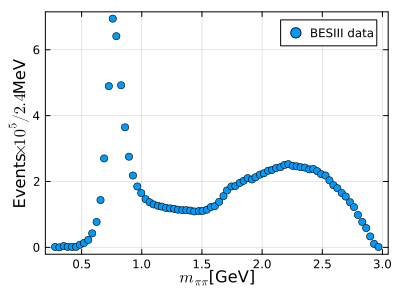

In [40]:
scatter(df_BESIII.Mpipi,df_BESIII.event,xlabel=L"$m_{\pi\pi}$[GeV]",ylabel=L"Events$\times 10^5/2.4$MeV",label="BESIII data")

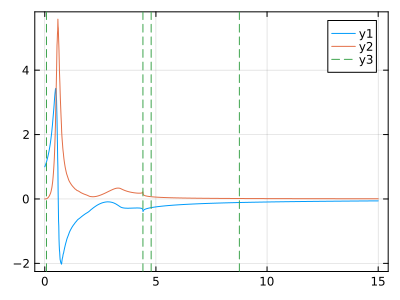

In [29]:
## the spike results from the inequal numerical singularity at the seperation point
let sv=collect(0.0:0.01:15)
    Ω1_arr=Ω1_all.(sv)
    F1_arr=@. Ω1_arr+[disperfunc(s;nsub=1,Ft_arr=Ftilde_arr_initial,ϵ=1.0e-8,rtol=1e-3) for s in sv]
    plot(sv,real.(F1_arr))
    plot!(sv,imag.(F1_arr))
    vline!([4mpi^2,(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ^2-mpi^2)/2,(mJψ-mpi)^2],ls=:dash)
end

In [35]:
let sv=collect(0.0:0.01:15)
    Ω1_arr=Ω1_all.(sv)
    F1_arr=@. Ω1_arr+[disperfunc(s;nsub=1,Ft_arr=Ftilde_sub_mat[5],ϵ=1.0e-8,rtol=1e-3) for s in sv]
    F1a_arr=@. Ω1_arr+[disperfunc(s;nsub=2,Ft_arr=Ftilde_a_mat[9],ϵ=1.0e-8,rtol=1e-3) for s in sv]
    F1b_arr=@. Ω1_arr*sv+[disperfunc(s;nsub=2,Ft_arr=Ftilde_b_mat[9],ϵ=1.0e-8,rtol=1e-3) for s in sv]

    global F1func=LinearInterpolation(sv,F1_arr,extrapolation_bc=Line())
    global F1afunc=LinearInterpolation(sv,F1a_arr,extrapolation_bc=Line())
    global F1bfunc=LinearInterpolation(sv,F1b_arr,extrapolation_bc=Line())
    nothing
end

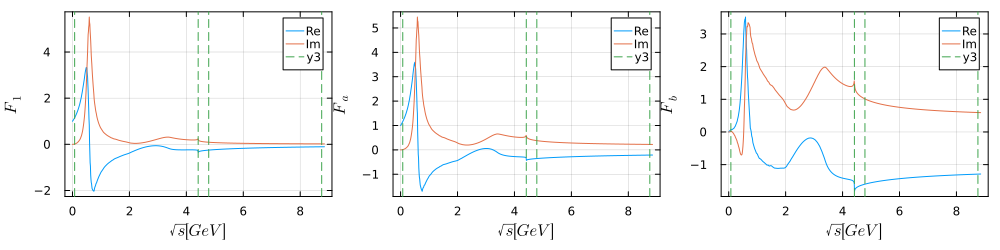

In [36]:
# the spike at (4*mpi^2+(mJψ-mpi)^2)/2 results from the numerical singularity and I just forget about it here
let sv=collect(0.0:0.01:(mJψ-mpi)^2+0.1)
    resv1,resv2,resv3=F1func.(sv),F1afunc.(sv),F1bfunc.(sv)
    plt1=plot(sv,real.(resv1),xlabel=L"\sqrt{s}[GeV]",ylabel=L"F_1",label="Re",bottom_margin=7mm,left_margin=5mm)
    plot!(sv,imag.(resv1),label="Im")
    vline!([4mpi^2,(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ^2-mpi^2)/2,(mJψ-mpi)^2],ls=:dash)
    plt2=plot(sv,real.(resv2),xlabel=L"\sqrt{s}[GeV]",ylabel=L"F_a",label="Re")
    plot!(sv,imag.(resv2),label="Im")
    vline!([4mpi^2,(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ^2-mpi^2)/2,(mJψ-mpi)^2],ls=:dash)
    plt3=plot(sv,real.(resv3),xlabel=L"\sqrt{s}[GeV]",ylabel=L"F_b",label="Re")
    plot!(sv,imag.(resv3),label="Im")
    vline!([4mpi^2,(4*mpi^2+(mJψ-mpi)^2)/2,(mJψ^2-mpi^2)/2,(mJψ-mpi)^2],ls=:dash)
    
    plot(plt1,plt2,plt3,layout=(1,3),size=(1000,250))
end

In [43]:
ϕfunc(s,t,u)=s*t*u-mpi^2*(mJψ^2-mpi^2)^2

function integrand(paras,m12sq,m23sq)
    a,b=paras
    m13sq=mJψ^2+3*mpi^2-m12sq-m23sq
    amp=zero(ComplexF64)
    amp+=a*F1afunc(m12sq)+b*F1bfunc(m12sq)
    amp+=a*F1afunc(m23sq)+b*F1bfunc(m23sq)
    amp+=a*F1afunc(m13sq)+b*F1bfunc(m13sq)

    return 1/(2*π)^3/(32*mJψ^3)/3/4*ϕfunc(m12sq,m13sq,m23sq)*abs(amp)^2
end

function distr(m12,paras;rtol=1e-3)  #distribution function
    M,m1,m2,m3=mJψ,mpi,mpi,mpi
    m12sq=m12^2
    E2star,E3star=(m12sq-m1^2+m2^2)/(2*m12),(M^2-m12sq-m3^2)/(2*m12)
    s23min=(E2star+E3star)^2-(sqrt(abs(E2star^2-m2^2))+sqrt(abs(E3star^2-m3^2)))^2
    s23max=(E2star+E3star)^2-(sqrt(abs(E2star^2-m2^2))-sqrt(abs(E3star^2-m3^2)))^2
    
    2*m12*quadgk(s23->integrand(paras,m12sq,s23),s23min,s23max;rtol=rtol)[1]
end

distr (generic function with 1 method)

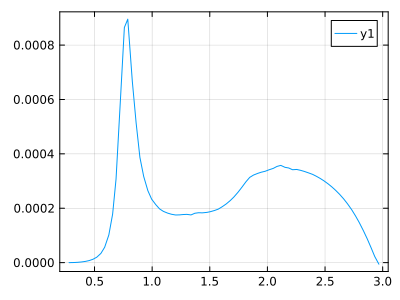

In [47]:
# distr(2*mpi+0.1,[1.0,0.198*exp(im*2.675)])
let paras=[1.0,0.198*exp(im*2.675)]
    xv=df_BESIII.Mpipi
    dis_arr=[distr(e,paras) for e in xv]
    plot(xv,dis_arr)
end

In [45]:
length(df_BESIII.Mpipi)

80

In [51]:
function fcn(N,a,ϕa,b,ϕb;num=80)
    paras=[a*exp(im*ϕa),b*exp(im*ϕb)]
    χsq=zero(Float64)
    for i in 1:num
        χsq+=(df_BESIII.event[i]-N*distr(df_BESIII.Mpipi[i],paras))^2
    end
    return χsq/num
end

fcn (generic function with 1 method)

## using PyCall to call iminuit from python package

In [49]:
using PyCall;
piminuit=pyimport("iminuit");

In [52]:
let # fixing a&b to get the approximate normalization factor
    _N,_a,_ϕa,_b,_ϕb=[1.0,1.0,0.0,0.198,2.675]
    tmp_model=piminuit.Minuit(fcn,N=_N,a=_a,ϕa=_ϕa,b=_b,ϕb=_ϕb,name=("N","a","ϕa","b","ϕb"))
    set!(tmp_model.fixed,"a",true);set!(tmp_model.fixed,"ϕa",true);
    set!(tmp_model.fixed,"b",true);set!(tmp_model.fixed,"ϕb",true);
    global fitres1= piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=7.187439693679827e-22 edm_goal=0.0002 errordef=1.0 fval=0.026761976088902066 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=20 ngrad=0 reduced_chi2=nan time=0.38598883400845807>
(Param(number=0, name='N', value=7179.593608901037, error=3403.8966471716644, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='a', value=1.0, error=0.01, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='ϕa', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='b', value=0.198, error=0.00198, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=4, name='ϕb', value=2.675, error=0.02675, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None))
[[11586512.3846265        0.               0.               0.
         0.       ]
 [       0.               0.               0.               0.
         0.       ]
 [       0.               0.               0.               0.
         0.       ]
 [       0.               0.               0.               0.
         0.       ]
 [       0.               0.               0.               0.
         0.       ]]

In [53]:
fitres1.values

PyObject <ValueView N=7179.593608901037 a=1.0 ϕa=0.0 b=0.198 ϕb=2.675>

In [54]:
let # fixing a to get the subtraction b
    _N,_a,_ϕa,_b,_ϕb=[7200,1.0,0.0,0.198,2.675]
    tmp_model=piminuit.Minuit(fcn,N=_N,a=_a,ϕa=_ϕa,b=_b,ϕb=_ϕb,name=("N","a","ϕa","b","ϕb"))
    set!(tmp_model.fixed,"a",true);set!(tmp_model.fixed,"ϕa",true);
    # set!(tmp_model.fixed,"b",true);set!(tmp_model.fixed,"ϕb",true);
    global fitres2= piminuit.Minuit.migrad(tmp_model) 
end

PyObject <FMin algorithm='Migrad' edm=4.801317624796544e-05 edm_goal=0.0002 errordef=1.0 fval=0.00857402120938686 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=64 ngrad=0 reduced_chi2=nan time=1.0369813750003232>
(Param(number=0, name='N', value=8172.215546551906, error=8961.70886707101, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=1, name='a', value=1.0, error=0.01, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=2, name='ϕa', value=0.0, error=0.1, merror=None, is_const=False, is_fixed=True, lower_limit=None, upper_limit=None), Param(number=3, name='b', value=0.22767806725196205, error=0.7160587381476111, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None), Param(number=4, name='ϕb', value=2.7875888231473547, error=3.1923098380545367, merror=None, is_const=False, is_fixed=False, lower_limit=None, upper_limit=None))
[[ 8.03122258e+07  0.00000000e+00  0.00000000e+00  3.91455062e+03
  -4.23552005e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.91455062e+03  0.00000000e+00  0.00000000e+00  5.12740116e-01
  -1.94033517e+00]
 [-4.23552005e+03  0.00000000e+00  0.00000000e+00 -1.94033517e+00
   1.01908421e+01]]

In [55]:
fitres2.values

PyObject <ValueView N=8172.215546551906 a=1.0 ϕa=0.0 b=0.22767806725196205 ϕb=2.7875888231473547>

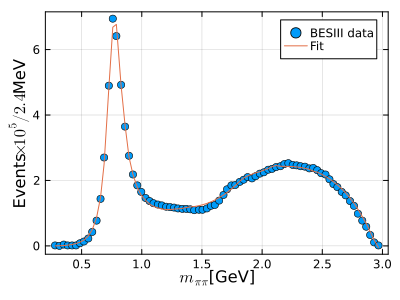

In [57]:
let
    N,a,ϕa,b,ϕb=[fitres2.values[i] for i in 1:5]
    scatter(df_BESIII.Mpipi,df_BESIII.event,xlabel=L"$m_{\pi\pi}$[GeV]",ylabel=L"Events$\times 10^5/2.4$MeV",label="BESIII data")
    xv=df_BESIII.Mpipi
    dis_arr=[N*distr(e,[a*exp(im*ϕa),b*exp(im*ϕb)]) for e in xv]
    plot!(xv,dis_arr,label="Fit")
end